2024-01-01 14:14:16.493452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


iteration: 0: cost is: 1.968822
iteration: 5: cost is: 0.813507
iteration: 10: cost is: 0.270873
iteration: 15: cost is: 0.101530
iteration: 20: cost is: 0.021344
iteration: 25: cost is: 0.006370
iteration: 30: cost is: 0.003202
iteration: 35: cost is: 0.002140
iteration: 40: cost is: 0.001509
iteration: 45: cost is: 0.001184
iteration: 50: cost is: 0.000914
iteration: 55: cost is: 0.000712
iteration: 60: cost is: 0.000586
iteration: 65: cost is: 0.000506
iteration: 70: cost is: 0.000428
iteration: 75: cost is: 0.000358
iteration: 80: cost is: 0.000312
iteration: 85: cost is: 0.000270
iteration: 90: cost is: 0.000237
iteration: 95: cost is: 0.000213
Train Accuracy: 1.0
Test Accuracy: 0.85833335


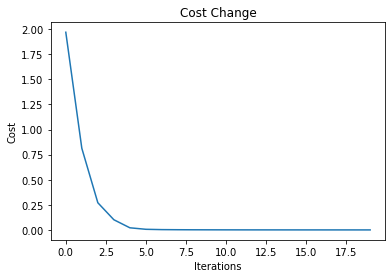

In [5]:
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import numpy as np
import math

def random_mini_batches(X, y, mini_batch_size=64, seed=0):
    m = X.shape[0]
    mini_batches = []

    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_y = y[permutation]

    size = math.floor(m / mini_batch_size)

    for k in range(0, size):
        mini_batch_X = shuffled_X[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_y = shuffled_y[k * mini_batch_size: (k + 1) * mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[size * mini_batch_size: m]
        mini_batch_y = shuffled_y[size * mini_batch_size: m]

        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)

    return mini_batches

def convert_to_one_hot(y, C):
    y = np.eye(C)[y.reshape(-1)].T
    return y

def load_dataset():
    train_dataset = h5py.File('Downloads/train_signs.h5', "r")
    X_train_orig = np.array(train_dataset["train_set_x"][:])
    y_train_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('Downloads/test_signs.h5', "r")
    X_test_orig = np.array(test_dataset["test_set_x"][:])
    y_test_orig = np.array(test_dataset["test_set_y"][:])

    y_train_orig = y_train_orig.reshape((1, y_train_orig.shape[0]))
    y_test_orig = y_test_orig.reshape((1, y_test_orig.shape[0]))

    X_train = X_train_orig / 255.0
    X_test = X_test_orig / 255.0
    y_train = convert_to_one_hot(y_train_orig, 6).T
    y_test = convert_to_one_hot(y_test_orig, 6).T

    return X_train, y_train, X_test, y_test

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    #X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    #y = tf.placeholder(tf.float32, shape=[None, n_y])
    y = tf.compat.v1.placeholder(tf.float32, shape=[None, n_y])
    return X, y

def initialize_parameters():
    tf.random.set_seed(1)

    W1 = tf.Variable(tf.initializers.GlorotUniform(seed=0)([3, 3, 3, 8]), name="W1", trainable=True)
    W2 = tf.Variable(tf.initializers.GlorotUniform(seed=0)([3, 3, 8, 16]), name="W2", trainable=True)
    parameters = {"W1": W1, "W2": W2}
    return parameters

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters["W2"]

    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    P2 = tf.keras.layers.Flatten()(P2)

    Z3 = tf.keras.layers.Dense(6, activation=None)(P2)

    return Z3

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

def model(X_train, y_train, X_test, y_test, learning_rate=0.009, num_epochs=100, minibatch_size=64):
    tf.compat.v1.disable_eager_execution()  # Disable eager execution for compatibility

    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = y_train.shape[1]

    X, y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, y)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)

    init = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session() as sess:
        sess.run(init)

        costs = []

        seed = 3

        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)

            seed = seed + 1

            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_y) = minibatch

                _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, y: minibatch_y})

                minibatch_cost += temp_cost / num_minibatches

            if epoch % 5 == 0:
                print("iteration: %i: cost is: %f" % (epoch, minibatch_cost))
                costs.append(minibatch_cost)

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, y: y_train})
        test_accuracy = accuracy.eval({X: X_test, y: y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        plt.plot(np.squeeze(costs))
        plt.ylabel("Cost")
        plt.xlabel("Iterations")
        plt.title("Cost Change")
        plt.show()

    return train_accuracy, test_accuracy, parameters

if __name__ == '__main__':
    X_train, y_train, X_test, y_test = load_dataset()
    _, _, parameters = model(X_train, y_train, X_test, y_test)